In [27]:
from drop_lib3 import *
from scipy.io import loadmat
import pickle
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

directory = 'spectrogram' # STFT (2D)
directory_to_save(directory)
verbose = 1
data = load_data(verbose=verbose)
speed_labels = data['speed_labels']
volume_labels = data['volume_labels']
unique_speeds = data['unique_speeds']
unique_volumes = data['unique_volumes']


Loaded segments shape: (842, 25000)
Speed labels shape: (842,)
Volume labels shape: (842,)
Unique speeds: [1.72 2.08 2.36 2.64 3.13 3.39 3.42]
Unique volumes: [55 77]


In [8]:
from scipy.signal import periodogram, spectrogram

def extract_spectrogram_features(signals, window='boxcar', fs=44100):
    features = []
    for signal in signals:
        f, t, Sxx = spectrogram(signal, fs=fs,
                                scaling='spectrum',
                                window=window,
                                nperseg=2**11,
                                noverlap=2**10,
                                nfft=2**12)
        features.append(Sxx)
    return f, t, np.array(features)

# Extract spectrogram features
f, t, X_spectrogram = extract_spectrogram_features(data['segments'])
print(f'Spectrogram shape: {X_spectrogram.shape} with {f.shape[0]} frequency bins and {t.shape[0]} time bins')
eps = 1e-7
X_spectrogram = 10*np.log10(X_spectrogram + eps)
print(f'Spectrogram range (dB): [{np.min(X_spectrogram.flatten()):.2f}, {np.max(X_spectrogram.flatten()):.2f}]')

Spectrogram shape: (842, 2049, 23) with 2049 frequency bins and 23 time bins
Spectrogram range (dB): [-70.00, -14.19]


In [17]:
number_of_features_to_select = 1000
X = X_spectrogram

def extract_features_labels2(X, y, f, t, score_func, number_of_features_to_select, n_jobs=9):
    if score_func == mutual_info_classif: # parallel speed up
        selector = SelectKBest(lambda X, y: score_func(X, y, n_jobs=n_jobs), k=number_of_features_to_select)
    else:
        selector = SelectKBest(score_func, k=number_of_features_to_select)
    X = X.reshape(X.shape[0], -1)
    X_selected = selector.fit_transform(X, y)
    idx = selector.get_support(indices=True)
    score = selector.scores_[idx]
    idx_sorted = idx[np.argsort(score)][::-1]
    #
    t_len = len(t)
    f_indices = idx_sorted // t_len  # frequency indices
    t_indices = idx_sorted % t_len   # time indices
    selected_frequencies = f[f_indices]
    selected_times = t[t_indices]
    # print(idx_sorted)
    # print(selected_frequencies[0:10])
    return X_selected, idx_sorted, score, selected_frequencies, selected_times

X_speed, idx_speed, score_speed, f_speed, t_speed = extract_features_labels2(X, speed_labels, f, t, f_classif, number_of_features_to_select)
X_volume, idx_volume, score_volume, f_volume, t_volume = extract_features_labels2(X, volume_labels, f, t, mutual_info_classif, number_of_features_to_select)

C:\Users\Administrator\anaconda3\envs\sklearn16\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Administrator\anaconda3\envs\sklearn16\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


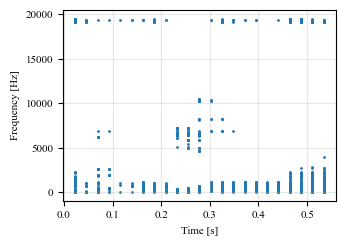

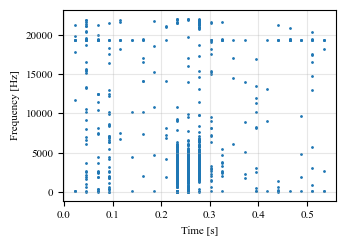

In [18]:
# plot the selected features
plt.figure(figsize=(3.5, 2.5))
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 8
plt.scatter(t_speed, f_speed, s=1)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(directory + '/' + 'selected_features_speed.pdf', bbox_inches='tight', transparent=True)
plt.savefig(directory + '/' + 'selected_features_speed.jpeg', dpi=300)
plt.show()
plt.figure(figsize=(3.5, 2.5))
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 8
plt.scatter(t_volume, f_volume, s=1)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(directory + '/' + 'selected_features_volume.pdf', bbox_inches='tight', transparent=True)
plt.savefig(directory + '/' + 'selected_features_volume.jpeg', dpi=300)
plt.show()

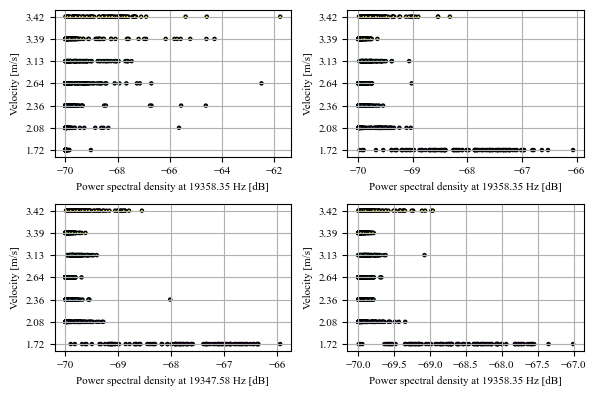

In [19]:
plt.figure(figsize=(6, 4))
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 8
for k in range(4):
    feature = X_speed[:, np.argsort(score_speed)[-k]]
    plt.subplot(2, 2, k+1)
    plt.scatter(feature, speed_labels, c=speed_labels, cmap='viridis', edgecolor='k', s=5)
    plt.xlabel(f'Power spectral density at {f_speed[k]:.2f} Hz [dB]')
    plt.ylabel('Velocity [m/s]')
    plt.yticks(ticks=np.arange(0, len(unique_speeds)), labels=unique_speeds)
    plt.grid(True)
plt.tight_layout()
plt.savefig(directory + '/' + 'scatter_plot_speed.pdf', bbox_inches='tight', transparent=True)
plt.savefig(directory + '/' + 'scatter_plot_speed.jpeg', dpi=300)
plt.show()

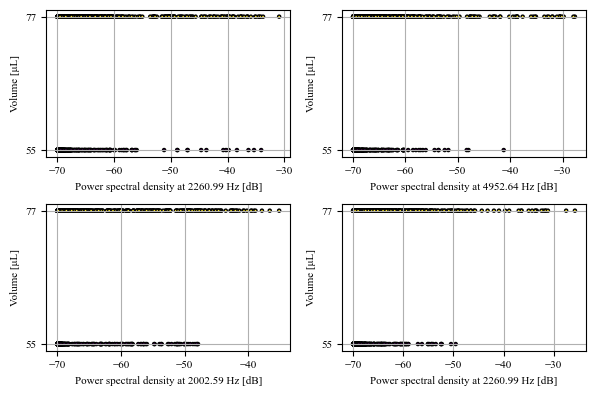

In [21]:
plt.figure(figsize=(6, 4))
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 8
for k in range(4):
    feature = X_volume[:, np.argsort(score_volume)[-k]]
    plt.subplot(2, 2, k+1)
    plt.scatter(feature, volume_labels, c=volume_labels, cmap='viridis', edgecolor='k', s=5)
    plt.xlabel(f'Power spectral density at {f_volume[k]:.2f} Hz [dB]')
    plt.ylabel('Volume [μL]')
    plt.yticks(ticks=np.arange(0, len(unique_volumes)), labels=unique_volumes)
    plt.grid(True)
plt.tight_layout()
plt.savefig(directory + '/' + 'scatter_plot_volume.pdf', bbox_inches='tight', transparent=True)
plt.savefig(directory + '/' + 'scatter_plot_volume.jpeg', dpi=300)
plt.show()

In [26]:
# Define the parameter grid for HistGradientBoostingClassifier
param_grid_hgb = {
    'histgradientboostingclassifier__max_iter': [100, 250],
    'histgradientboostingclassifier__max_depth': [10, 50]
}

# Create a pipeline with StandardScaler and HistGradientBoostingClassifier
pipeline_speed = make_pipeline(StandardScaler(), HistGradientBoostingClassifier())
pipeline_volume = make_pipeline(StandardScaler(), HistGradientBoostingClassifier())

# Perform grid search for HistGradientBoostingClassifier
grid_search_hgb_speed = GridSearchCV(pipeline_speed, param_grid_hgb, cv=2, n_jobs=9, verbose=10)
grid_search_hgb_volume = GridSearchCV(pipeline_volume, param_grid_hgb, cv=2, n_jobs=9, verbose=10)
grid_search_hgb_speed.fit(X_speed, speed_labels)
grid_search_hgb_volume.fit(X_volume, volume_labels)
best_hgb_speed_params = grid_search_hgb_speed.best_params_
best_hgb_volume_params = grid_search_hgb_volume.best_params_
print(f'Best parameters for HGB speed: {best_hgb_speed_params}')
print(f'Best parameters for HGB volume: {best_hgb_volume_params}')

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best parameters for HGB speed: {'histgradientboostingclassifier__max_depth': 10, 'histgradientboostingclassifier__max_iter': 100}
Best parameters for HGB volume: {'histgradientboostingclassifier__max_depth': 10, 'histgradientboostingclassifier__max_iter': 100}


 20%|██        | 1/5 [00:12<00:51, 12.90s/it]

Velocity accuracy (fold): 0.9763


 40%|████      | 2/5 [00:26<00:40, 13.40s/it]

Velocity accuracy (fold): 0.9822


 60%|██████    | 3/5 [00:42<00:29, 14.61s/it]

Velocity accuracy (fold): 0.9762


 80%|████████  | 4/5 [00:55<00:13, 13.88s/it]

Velocity accuracy (fold): 0.9881


100%|██████████| 5/5 [01:07<00:00, 13.45s/it]


Velocity accuracy (fold): 0.9881
Velocity accuracy average across all folds: 0.9822±0.0053


 20%|██        | 1/5 [00:03<00:14,  3.56s/it]

Volume accuracy (fold): 0.8817


 40%|████      | 2/5 [00:07<00:10,  3.51s/it]

Volume accuracy (fold): 0.8876


 60%|██████    | 3/5 [00:10<00:06,  3.43s/it]

Volume accuracy (fold): 0.9107


 80%|████████  | 4/5 [00:13<00:03,  3.42s/it]

Volume accuracy (fold): 0.9286


100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

Volume accuracy (fold): 0.9107
Volume accuracy average across all folds - : 0.9038±0.0171
Results saved in directory: ./spectrogram/
[[102   0   1   0   0   0   0]
 [  0 121   0   0   0   1   0]
 [  0   0 111   1   1   0   0]
 [  0   0   1 181   0   0   0]
 [  0   0   0   0  83   0   5]
 [  0   2   0   3   0 137   0]
 [  0   0   0   0   0   0  92]]
[[329  40]
 [ 41 432]]


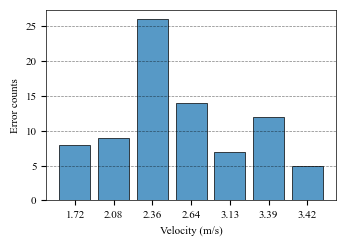

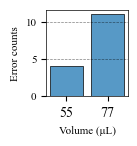

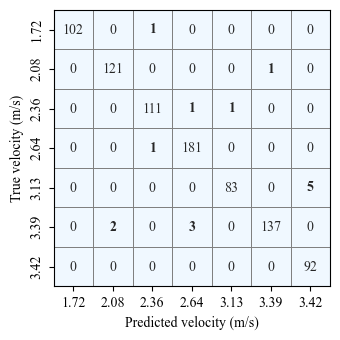

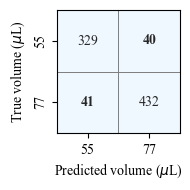

In [29]:
# Train the models with the best parameters
best_hgb_speed = make_pipeline(HistGradientBoostingClassifier(**{k.split('__')[1]: v for k, v in best_hgb_speed_params.items()}))
best_hgb_volume = make_pipeline(HistGradientBoostingClassifier(**{k.split('__')[1]: v for k, v in best_hgb_volume_params.items()}))

confusion_matrices_speed, error_indices_speed, all_cv_scores_speed, \
confusion_matrices_volume, error_indices_volume, all_cv_scores_volume\
    = evaluate_classifier(best_hgb_speed, best_hgb_volume, X_speed, X_volume, data, random_state=42)
save_results(confusion_matrices_speed, error_indices_speed, all_cv_scores_speed,
             confusion_matrices_volume, error_indices_volume, all_cv_scores_volume,
             data,
             directory=directory, verbose=verbose)
plot_results(confusion_matrices_speed, error_indices_speed,
             confusion_matrices_volume, error_indices_volume,
             data,
             directory=directory, verbose=verbose)